In [88]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import functions_ml as fml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss, f1_score, jaccard_score, accuracy_score, multilabel_confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram
# Set font properties globally (Times New Roman and font size 14)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

In [89]:
# PARAMETERS
BINARY_CLASSIFICATON = False
TOLERANCE_LIMIT = 0.01 / 100

# 1. Get dataset
results = pd.read_csv('../datasets/instances_results.csv')
features = pd.read_csv('../datasets/multi_plant_instance_features.csv')
dataset = fml.create_dataset(features, results)

In [90]:
timeset = dataset[['instance'] + [c for c in dataset.columns if c.startswith('Time')]]

In [91]:
timeset.describe()

,Time_RF_1_0,Time_RF_2_0,Time_RF_2_1,Time_RF_3_0,Time_RF_3_1,Time_RF_3_2,Time_RF_4_0,Time_RF_4_1,Time_RF_4_2,Time_RF_4_3,Time_RF_6_0,Time_RF_6_1,Time_RF_6_2,Time_RF_6_3,Time_RF_6_4,Time_RF_6_5,Time_RF_T_0
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,489.312542,637.379607,751.300301,786.062525,804.293478,956.460368,900.096656,906.516054,1002.723411,1098.923746,1112.207358,921.087726,1079.927926,1172.170033,1222.633595,1317.425535,1419.495318
std,659.378782,714.281894,756.491696,761.753707,736.307269,786.311680,771.032542,742.966647,771.751527,757.903212,758.818835,618.364274,718.321033,736.388911,723.608084,681.521288,617.740087
min,0.600000,0.650000,0.650000,0.760000,0.900000,1.600000,0.600000,0.500000,1.000000,2.000000,0.820000,1.110000,0.900000,0.920000,1.560000,3.250000,1.200000
25%,12.825000,19.830000,35.127500,38.635000,50.175000,87.875000,80.275000,82.175000,121.150000,219.550000,194.840000,225.185000,232.950000,288.402500,361.915000,607.322500,1010.375000
50%,83.400000,160.635000,316.170000,423.990000,570.550000,1081.400000,798.300000,953.650000,1253.550000,1545.350000,1563.945000,1200.735000,1259.000000,1716.225000,1800.165000,1800.420000,1800.100000
75%,944.575000,1416.110000,1617.502500,1619.770000,1525.525000,1800.600000,1800.200000,1766.450000,1800.500000,1801.100000,1800.290000,1273.185000,1800.300000,1800.467500,1800.627500,1801.087500,1800.200000
max,1805.500000,1802.010000,1804.310000,1802.280000,1803.800000,1806.700000,1803.500000,1802.200000,1803.100000,1806.400000,1803.020000,1801.960000,1803.400000,1802.910000,1803.250000,1807.760000,1803.100000


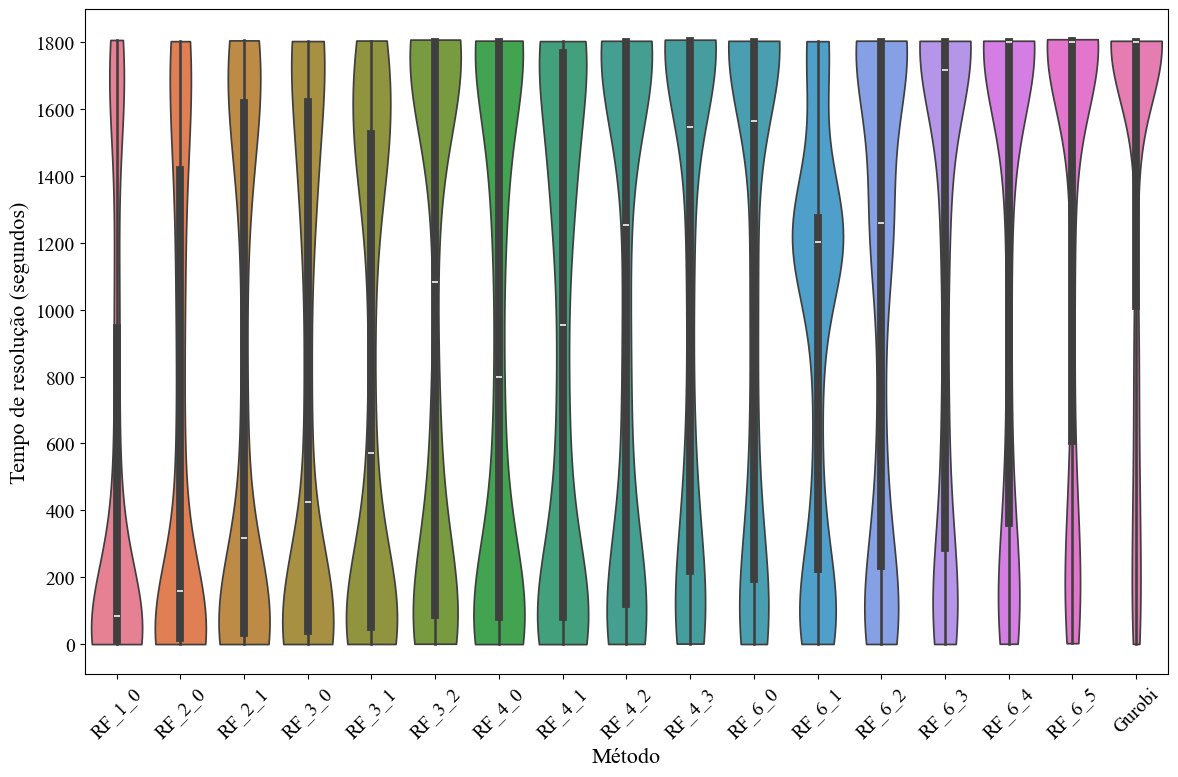

In [93]:
# Prepare the melted DataFrame for violin plotting
melted_timeset = timeset.melt(
    id_vars=['instance'], 
    var_name='Method', 
    value_name='Solving Time'
)

# Remove the "Time_" prefix from the Method column and rename RF_T_0 to "Gurobi"
melted_timeset['Method'] = melted_timeset['Method'].str.replace('Time_', '')
melted_timeset['Method'] = melted_timeset['Method'].replace({'RF_T_0': 'Gurobi'})

# Generate a violin plot with custom x-labels
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=melted_timeset, 
    x='Method', 
    y='Solving Time', 
    inner="box", 
    palette=None,
    hue='Method',
    legend=False,
    cut=0,
    fill=True,
)
plt.xlabel('Método', fontsize=16)
plt.ylabel('Tempo de resolução (segundos)', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
y_ticks = np.arange(0, melted_timeset['Solving Time'].max(), 200)
plt.yticks(y_ticks, fontsize=14)
plt.tight_layout()
plt.savefig('fig_violin_plot_solving_time.png', dpi=600, bbox_inches='tight')
plt.show()

# Teste de hipóteses

## Kruskal Wallis

In [120]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
stat, p_value = kruskal(*[timeset[col] for col in timeset.columns if col != 'instance'])
print(f"Kruskal-Wallis Test: statistic={stat:.4f}, p-value={p_value}")

Kruskal-Wallis Test: statistic=1106.7655, p-value=1.490006884041903e-225


## Dunn test

In [ ]:
import scikit_posthocs as sp

# Perform Dunn's test for pairwise comparisons using the melted DataFrame
posthoc = sp.posthoc_dunn(
    melted_timeset, 
    val_col='Solving Time',  # Column with values (times)
    group_col='Method',      # Column with groups (methods)
    p_adjust='bonferroni'    # Adjust for multiple comparisons
)

plt.figure(figsize=(12, 8))
sns.heatmap(posthoc, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=posthoc.columns, yticklabels=posthoc.columns)
plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('fig_dunn_test_solving_time.png', dpi=600, bbox_inches='tight')
plt.show()